## Development Notes

This notebook documents Daniel's attempt to re-create Evan's box-model. 

---

### LOG

- 1/14 12:45PM - *initial setup, reading code*


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='talk')

import numpy as np
import pandas as pd

/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The model itself is a simple, one-box model tracking the volume ($V$, in m$^3$), salinity ($S$, kg), nitrogen ($N$, probably mass?) and oxygen ($O$, again probably in mass?) in an estuary. 

For simplicity, we'll first whip up the model neglecting tidal inflow. In this case:

1. There is no time-dependent change in the tidal height; the water mass (volume) in the estuary remains constant with respect to time.

2. $S$ is lost to due to river flow.

3. Local net biological productivity, $J = P - R$, is given in terms of $N$ consumed to produce $O$ and is a function of a simple 24-hour cycle (daylight).

4. $N$ is consumed to produce $O$ but also transported via the river.

5. $O$ is produced from $N$ consumption but also transported via the river and exchanged in the gas phase.

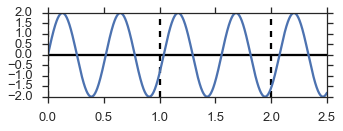

In [4]:
t_hours = np.linspace(0, 60., 1000.) # time, in hours

def tidal_flow(t, estuary_area=1.):
    """ Rate of tidal in/out-flow in m3/s as a function of 
    time (hours) """
    return 2.*estuary_area*np.sin(2.*np.pi*(t / 12.45))

tides = tidal_flow(t_hours)
plt.figure(figsize=(5,1.5))
plt.plot(t_hours/24., tides)
lo, hi = plt.ylim()
plt.vlines([0, 1, 2], lo, hi, linestyle='dashed', color='k')
plt.hlines(0, t_hours[0]/24., t_hours[-1]/24., color='k')

In [36]:
def box_model_ode(y, t, tide_func=lambda t: 0,
                  river_flow_rate=0.05, 
                  G=3., P=1., P_scale=1., V0=1e9, z=5.,
                  N_river=100., O_river=231.2, 
                  S_ocean=35., N_ocean=20., O_ocean=231.2):
    """ This encodes the instantaneous rate of change of the
    box model sytem, `y`, at a given instant in time, `t`. 
    
    Parameters
    ----------
    y : array
        The current volume, salinity, nitrogen, and ocean state
        variables:
            - V: m3
            - S: kg
            - N: mmol 
            - O: mmol 
    t : float
        The current evaluation time, in hours.
    tide_func : function
        A function of the argument `t` (again in hours) which yields
        the mass transport due to tidal inflow and outflow in m3/hr. 
        By convention, the function should return positive values for
        inflow and negative values for outflow.
    z : float
        Average estuary depth, in m
    river_flow_rate : float
        Fraction (preferably between 0 and 0.2) of river flow per day
        relative to estuary mean volume. Set to `0` to disable river
        flow
    V0: float
        Initial (average) estuary volume
    N_river, O_river : float
        Nitrogen and oxygen concentration in river in mmol m-3
    G : float
        Gas exchange rate in m/d, between 1 and 5
    P : float
        System productivity relative to normal conditions (P=1); may vary 
        between 0.5 (cloudy) and 2.0 (bloom)
    P_scale : float
        Factor to scale system productivity,
    S_ocean, N_ocean, O_ocean : floats
        Boundary condition concentrations for S, N, O in ocean and upriver
        sources. Because these are concentrations, S is kg/m3, and N and O
        are mmol/m3
    
    Returns
    -------
    dy_dt : array 
        Derivative of the current state-time.
        
    """
    
    # Un-pack current state
    V, S, N, O = y[:]   
    
    # Pre-compute terms which will be used in the derivative
    # calculations
   
    # 2) Biological production minus respiration
    # Note: there's clearly some sort of stoichiometry going on here, o
    #       need to find out what those reactions are. also, in Evan's
    #       production code (post-spin-up), this is scaled by the mean
    #       N value from the past 24 hours divided by the ocean N
    #       levels
    J = P*(125.*16./154.)*np.sin(2.*np.pi*(t + 0.75)/24.) # mmol/m2/day
    #J /= 24 # day-1 -> h-1
    
    # 3) Estuary avg surface exchange area
    A = V/z
    
    # 4) Current molar concentrations of N and O (to mmol / m3)
    S = S/V
    N = N/V
    O = O/V
    
    # 5) Tidal source gradients, given direction of tide
    tidal_flow = (V0/z)*tide_func(t)
    if tidal_flow > 0:
        tidal_S_contrib = tidal_flow*S_ocean
        tidal_N_contrib = tidal_flow*N_ocean
        tidal_O_contrib = tidal_flow*O_ocean
    else:
        # N/O are already in molar concentrations
        tidal_S_contrib = tidal_flow*S
        tidal_N_contrib = tidal_flow*N
        tidal_O_contrib = tidal_flow*O
        
    # Compute derivative terms
    dV_dt = tidal_flow
    dS_dt = -river_flow_rate*V0*S + tidal_S_contrib
    dN_dt = -J*A - river_flow_rate*V0*(N - N_river) \
          + tidal_N_contrib
    dO_dt = J*(154./16.)*A + (G/24.)*(O_river - O)*A \
          - river_flow_rate*V0*(O - O_river) \
          + tidal_O_contrib
        
    return np.array([dV_dt, dS_dt, dN_dt, dO_dt])

With caveats, that implements the basics of the model. Now, we can try to run it with some simple initial conditions. Note that we'll have to re-do the initial conditions since we aren't tracked species *densities* - just species *masses* or *molecular masses* (ideally the former, but need to check in and see equations)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1108bedd8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10fbb59e8>], dtype=object)

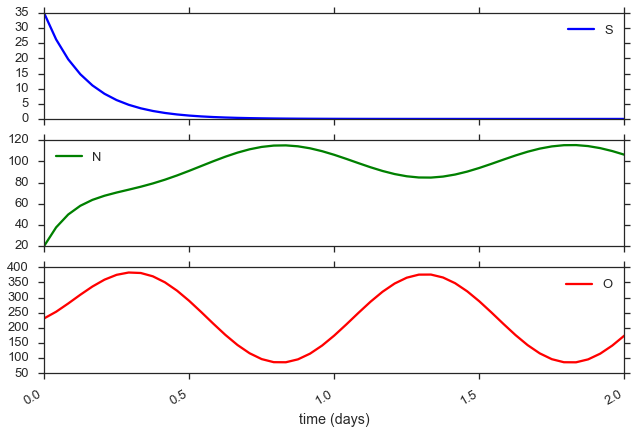

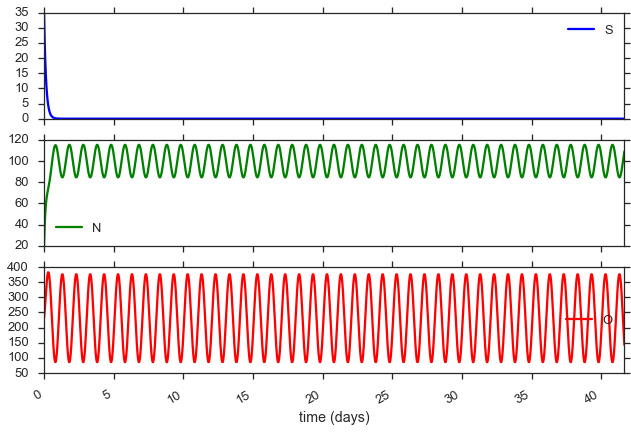

In [39]:
V0 = 1e9 # m3
S0 = 35. # kg/m3
N0 = 20. # mmol/m3
O0 = 231.2 # mmol/m3
N_river = 100. # mmol/m3
O_river = 231.2 # mmol/m3
y0 = np.array([V0, S0*V0, N0*V0, O0*V0])

from scipy.integrate import odeint

model_kwargs = dict(V0=V0, #tide_func=tidal_flow,
                    river_flow_rate=0.05, P=1.0, G=3.0,
                    N_river=N_river, O_river=O_river,
                    S_ocean=S0, N_ocean=N0, O_ocean=O0)

dt = 1.0 # hours
t0, t_end = 0., 1000., #24.*50 # hours
t_spinup = 24.*2 # hours

# Euler integration loop
out_y = np.vstack([y0, ])
ts = [t0, ]
t = t0
while t < t_end:
    # Pop last state off of stack
    y = out_y[-1].T
    
    # If we're past spin-up, then average the N concentration over
    # the last 24 hours to scale productivity
    if t > t_spinup:
        n_24hrs = int(np.ceil(24./dt))
        P_scale = np.mean(out_y[-n_24hrs:, 2]/out_y[-n_24hrs:, 0])/N0
        model_kwargs['P_scale'] = P_scale
    
    # Euler step
    t += dt
    new_y = y + dt*box_model_ode(y, t, **model_kwargs)
    
    # Correct non-physical V/S/N/O (< 0)
    new_y[new_y < 0] = 0.
    
    # Save output onto stack
    out_y = np.vstack([out_y, new_y])
    ts.append(t)

out = out_y[:]
ts = np.array(ts)
    
# Convert to DataFrame
df = pd.DataFrame(data=out, columns=['V', 'S', 'N', 'O'],
                  dtype=np.float32,
                  index=pd.Index(ts/24., name='time (days)'))

# Convert S -> kg/m3, N/O -> mmol/m3
df.S /= df.V
df.N /= df.V
df.O /= df.V

# Convert V -> percentage change relative to initial/avg
df.V = 100*(df.V - V0)/V0

df[['S', 'N', 'O']].ix[:2.].plot(subplots=True, sharex=True)
df[['S', 'N', 'O']].plot(subplots=True, sharex=True)


Save as a pandas DataFrame for easy plotting/saving

In [ ]:
df['S']